### TODO
- Date Format nicht notwendig, MESS_DATUM ist bereits numerisches Feature
- Leerzeichen aus feature namen 


In [68]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

def create_lag_features(data, lag_days, variables):
    for l in range(1,lag_days+1):
        for variable in variables:
            data[f'{variable}_lag_{l}'] = data[variable].shift(-l)
    return data

# Kapitel 1: Datenvorbereitung
1. Erstelle einen DataFrame für jede Wetterstation
2. Filtere die DataFrames auf einen Zeitraum, in dem für alle Orte Werte vorhanden sind
3. Kombiniere die Data Frames anhand von Datumsfeature 
4. Erstelle TimeLag Features
5. Fülle Fehlende Daten mit sinnvollen werten oder entferne Sie

In [69]:
file_path_ort1 = 'data/Schorndorf.csv'
file_path_ort2 = 'data/Arber.csv'
file_path_ort3 = 'data/Straubing.csv'

# Laden der Daten und Filtern nach Zeitraum
df_sch = pd.read_csv(file_path_ort1, parse_dates=['DATE'])
df_sch['DATE'] = pd.to_datetime(df_sch['DATE'], format='%d.%m.%Y')
df_sch = df_sch.query('DATE >= "1996-05-01"')
df_arb = pd.read_csv(file_path_ort2, parse_dates=['DATE'])
df_arb['DATE'] = pd.to_datetime(df_arb['DATE'], format='%d.%m.%Y')
df_arb = df_arb.query('DATE >= "1996-05-01"')
df_str = pd.read_csv(file_path_ort3, parse_dates=['DATE'])
df_str['DATE'] = pd.to_datetime(df_str['DATE'], format='%d.%m.%Y')
df_str = df_str.query('DATE >= "1996-05-01"')

#Zusammenführen der DataFrames
df_combined = pd.merge(df_sch, df_arb, how='inner', on='DATE', suffixes=('_sch', '_arb'))
df_combined = pd.merge(df_combined, df_str, how='inner', on='DATE')
#
df_combined_tl = create_lag_features(df_combined, lag_days=3, variables=[' NIEDERSCHLAGSHOEHE', ' LUFTTEMPERATUR'])
df_combined_tl.drop(df_combined_tl.tail(3).index, inplace=True)
df_combined_tl = df_combined.drop(['LUFTDRUCK_STATIONSHOEHE_sch', ' WINDGESCHWINDIGKEIT_sch',
                                   ' WINDSPITZE_MAXIMUM_sch', 'SONNENSCHEINDAUER_sch', 
                                   'LUFTTEMP_AM_ERDB_MINIMUM_arb'], axis=1)

print(df_combined_tl.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7181 entries, 0 to 7180
Data columns (total 50 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   DATE                          7181 non-null   datetime64[ns]
 1    MESS_DATUM_sch               7181 non-null   int64         
 2    QUALITAETS_NIVEAU_sch        7181 non-null   int64         
 3    LUFTTEMPERATUR_sch           7181 non-null   float64       
 4   DAMPFDRUCK_sch                7181 non-null   float64       
 5   BEDECKUNGSGRAD_sch            7181 non-null   float64       
 6   REL_FEUCHTE_sch               7181 non-null   float64       
 7    LUFTTEMPERATUR_MAXIMUM_sch   7181 non-null   float64       
 8   LUFTTEMPERATUR_MINIMUM_sch    7181 non-null   float64       
 9   LUFTTEMP_AM_ERDB_MINIMUM_sch  7181 non-null   float64       
 10   NIEDERSCHLAGSHOEHE_sch       7181 non-null   float64       
 11  NIEDERSCHLAGSHOEHE_IND_sch    

### TODO
- Heatmap anzeige bitte noch beheben

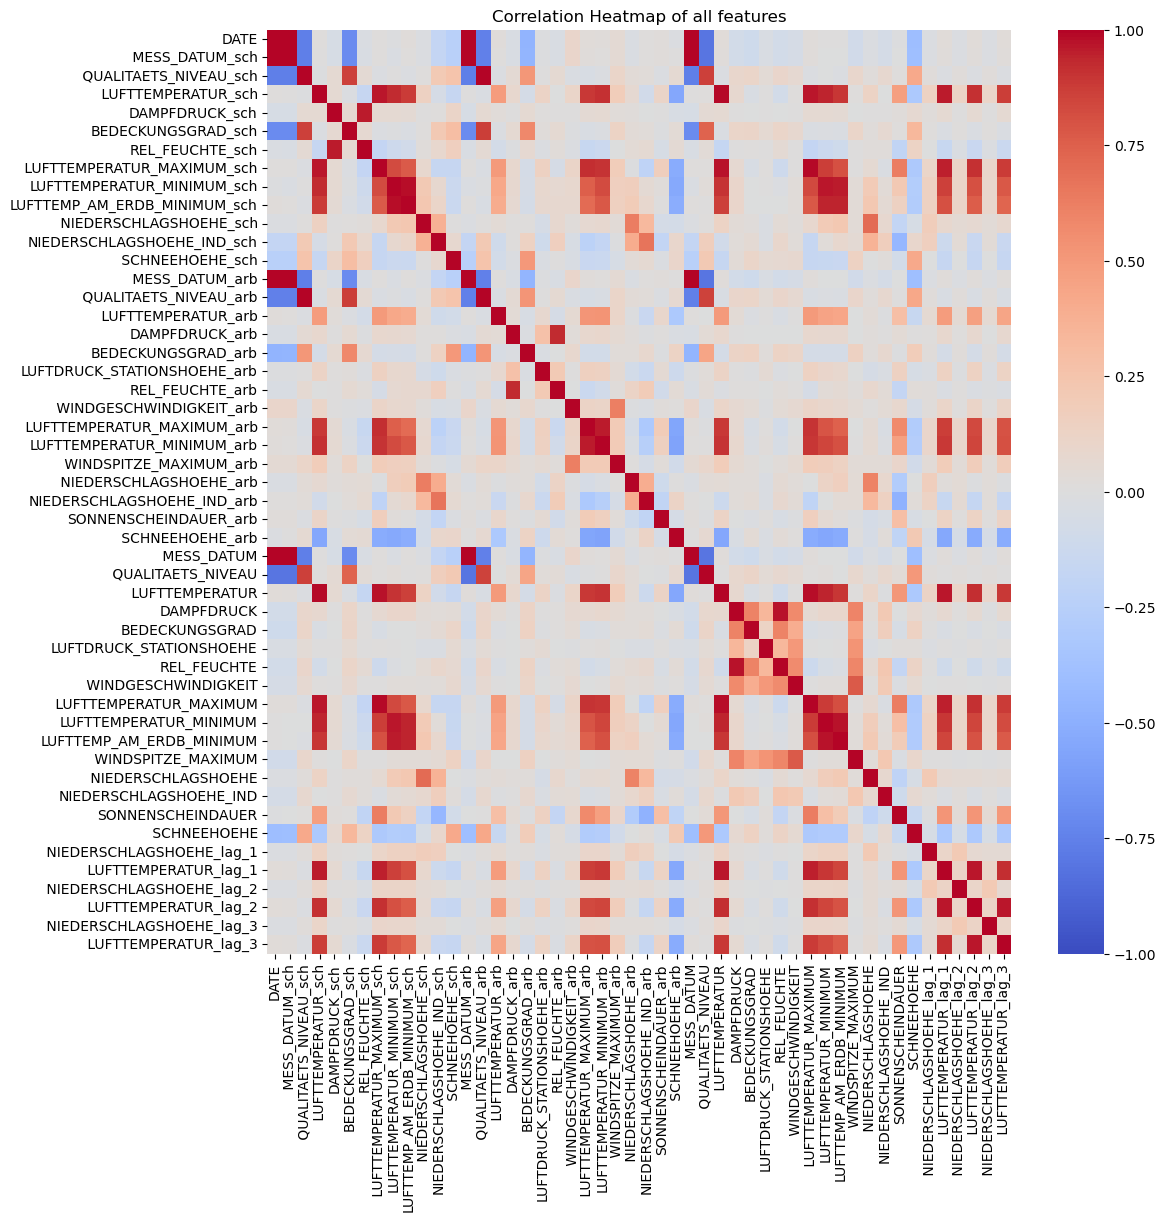

In [75]:
# Plot the corelation-heatmap
plt.figure(figsize=(12, 12))
sns.heatmap(df_combined_tl.corr(), cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap of all features')
plt.show()

### TODO
- Prüfen, ob miteinbeziehen des Qualitätsniveaus die Vorhersage verbessert
- Evtl Überlegungen bezügl. weiteren Features
- Vergleich alle features -> nur beste corr
- Niederschlag über alles mitteln
- Rest über vortag und nächsten tag mitteln
- drop features nur allgemeines, sonst evtl unterschiedliches X für y1 und y2
- evtl berücksichtigen ob ys die im aktuellen modell nicht vorhergesagt werden im modell bleiben sollten

# Kapitel 2: Lineares Modell

In [71]:
#Features sind keine werte die Einfluss auf Temperatur oder Niederschlag haben
drop_features = ['DATE', ' MESS_DATUM', ' MESS_DATUM_sch', ' MESS_DATUM_arb', 
                 ' LUFTTEMPERATUR_lag_1',' LUFTTEMPERATUR_lag_2' ,' LUFTTEMPERATUR_lag_3',
                 ' NIEDERSCHLAGSHOEHE_lag_1', ' NIEDERSCHLAGSHOEHE_lag_2', ' NIEDERSCHLAGSHOEHE_lag_3',
                 ' QUALITAETS_NIVEAU_sch' , ' QUALITAETS_NIVEAU_arb', ' QUALITAETS_NIVEAU']

X = df_combined_tl.drop(drop_features, axis=1)

y_temperature_lag_1 = df_combined_tl[' LUFTTEMPERATUR_lag_1']
y_temperature_lag_2 = df_combined_tl[' LUFTTEMPERATUR_lag_2']
y_temperature_lag_3 = df_combined_tl[' LUFTTEMPERATUR_lag_3']
y_precipiation_lag_1 = df_combined_tl[' NIEDERSCHLAGSHOEHE_lag_1']
y_precipiation_lag_2 = df_combined_tl[' NIEDERSCHLAGSHOEHE_lag_2']
y_precipiation_lag_3 = df_combined_tl[' NIEDERSCHLAGSHOEHE_lag_3']

### TODO
- lag für Tag 1 und 2 nach heute (3 done) '\' am ende von zeilen für übersichtlichkeit
- test size variieren

In [76]:
# Train Test Split
X_train, X_test, \
y1_l3_train, y1_l3_test, \
y2_l3_train, y2_l3_test = train_test_split(X, y_temperature_lag_3, y_precipiation_lag_3, test_size=0.20)

# Train Model for Temperature in 3d and make predictions
model_temp_lag_3 = LinearRegression()
model_temp_lag_3.fit(X_train, y1_l3_train)
y1_l3_train_pred = model_temp_lag_3.predict(X_train)
y1_l3_test_pred = model_temp_lag_3.predict(X_test)

# Train Model for Precipation in 3d and make predictions
model_prec_lag_3 = LinearRegression()
model_prec_lag_3.fit(X_train, y2_l3_train)
y2_l3_train_pred = model_prec_lag_3.predict(X_train)
y2_l3_test_pred = model_prec_lag_3.predict(X_test)

### TODO
- train test vertauscht bei ausgabe?

MSE für Temperatur in 3 Tagen (Training): 13.00014128885694
MSE für Temperatur in 3 Tagen (Test): 12.825328698143931
MSE für Niederschlag in 3 Tagen (Training): 16.897100309783845
MSE für Niederschlag in 3 Tagen (Test): 20.461733916050466


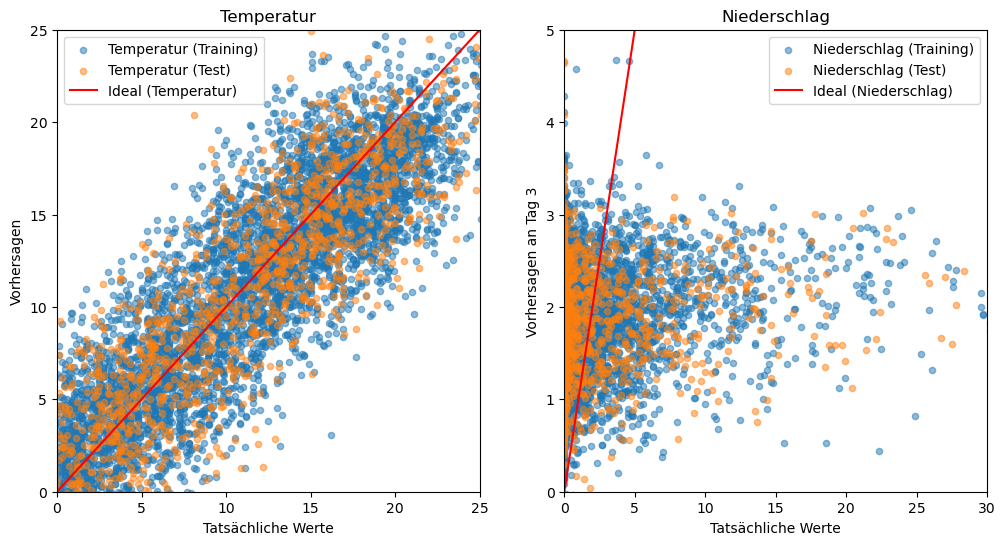

In [79]:
# Evaluate Models based on MSE
mse_y1_l3_train = mean_squared_error(y1_l3_train, y1_l3_train_pred)
mse_y1_l3_test = mean_squared_error(y1_l3_test, y1_l3_test_pred)

mse_y2_l3_train = mean_squared_error(y2_l3_train, y2_l3_train_pred)
mse_y2_l3_test = mean_squared_error(y2_l3_test, y2_l3_test_pred)

print("MSE für Temperatur in 3 Tagen (Training):", mse_y1_l3_train)
print("MSE für Temperatur in 3 Tagen (Test):", mse_y1_l3_test)

print("MSE für Niederschlag in 3 Tagen (Training):", mse_y2_l3_train)
print("MSE für Niederschlag in 3 Tagen (Test):", mse_y2_l3_test)

# Visualisiere die Abweichung der Vorhersagen von den tatsächlichen Werten für Temperatur
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(y1_l3_train, y1_l3_train_pred, label='Temperatur (Training)', alpha=0.5, s=20)
plt.scatter(y1_l3_test, y1_l3_test_pred, label='Temperatur (Test)', alpha=0.5, s=20)
max_value_y1_l3 = max(max(y1_l3_train), max(y1_l3_test), max(y1_l3_train_pred), max(y1_l3_test_pred))
plt.plot([-10, max_value_y1_l3], [-10, max_value_y1_l3], linestyle='-', color='red', label='Ideal (Temperatur)')
plt.xlim(0, 25)
plt.ylim(0, 25)
plt.xlabel('Tatsächliche Werte')
plt.ylabel('Vorhersagen')
plt.title('Temperatur')
plt.legend()

# Visualisiere die Abweichung der Vorhersagen von den tatsächlichen Werten für Niederschlag
plt.subplot(1, 2, 2)
plt.scatter(y2_l3_train, y2_l3_train_pred, label='Niederschlag (Training)', alpha=0.5, s=20)
plt.scatter(y2_l3_test, y2_l3_test_pred, label='Niederschlag (Test)', alpha=0.5, s=20)
max_value_y2_l3 = max(max(y2_l3_train), max(y2_l3_test), max(y2_l3_train_pred), max(y2_l3_test_pred))
plt.plot([-10, max_value_y2_l3], [-10, max_value_y2_l3], linestyle='-', color='red', label='Ideal (Niederschlag)')
plt.xlim(0, 30)
plt.ylim(0, 5)
plt.xlabel('Tatsächliche Werte')
plt.ylabel('Vorhersagen an Tag 3')
plt.title('Niederschlag')
plt.legend()

# Zeige die Plots an
plt.show()

In [78]:
#Diese Zelle für plot bzgl. MSE
#Boxplot für MSE pro Tag und Zielgröße

## Temperatur
Linearer Zusammenhang deutlich erkennbar, MSE aber noch zu hoch? Modell grundsätzlich korrekt.

## Niederschlag
Vorhersage schwankt um Wert 2.
Modell schlecht, da kein Linearer Zusammenhang zwischen den Features (systematischer Fehler) vor 3 Tagen und dem Niederschlag heute besteht. Time Lag zu groß, daher keine korelation (auch erkennbar in heatmap)

### TODO
- Verbesserung der Ergebnisse der Multivarianten Linearen Regression durch verwendung der Polynomialen Regression als Erweiterung

### 2. Lineares Modell Lasso/Ridge Regression ???

